In [1]:
!pip install statsforecast utilsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("daily_sales_french_bakery", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


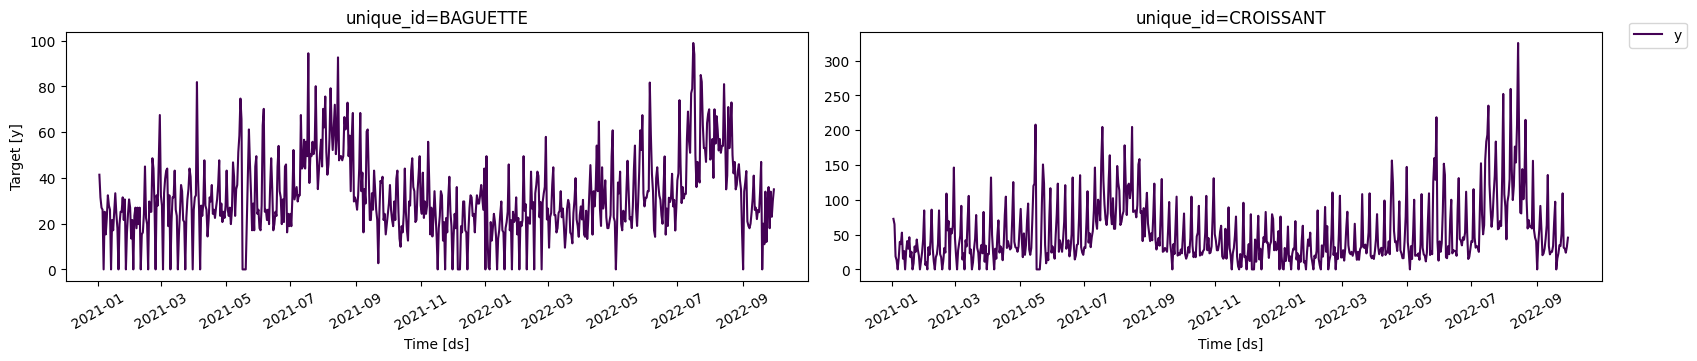

In [4]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

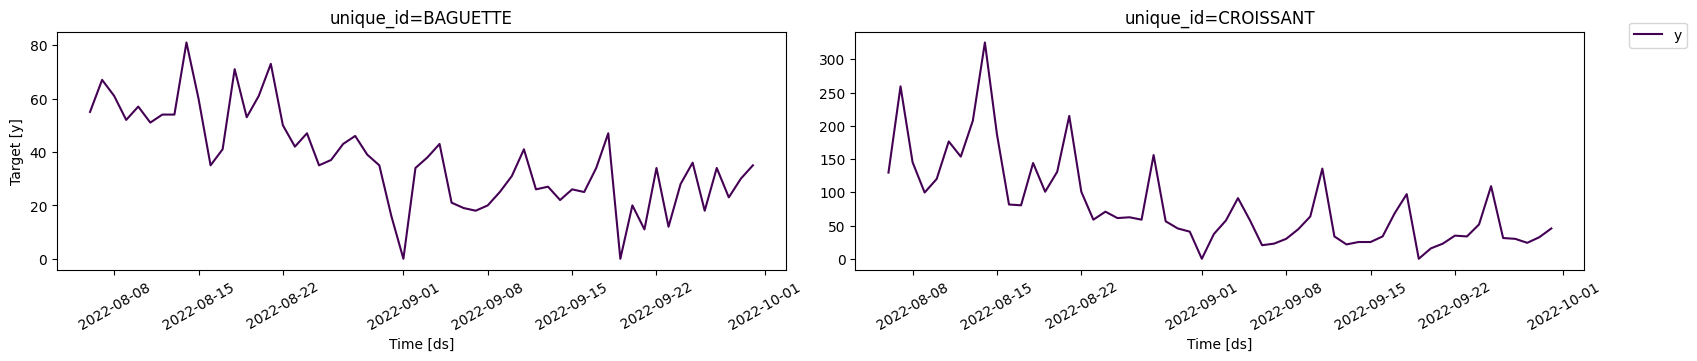

In [5]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

In [6]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [7]:
horizon = 7
models = [Naive(), HistoricAverage(), WindowAverage(window_size=7), SeasonalNaive(season_length=7)]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds=sf.predict(h=horizon)
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


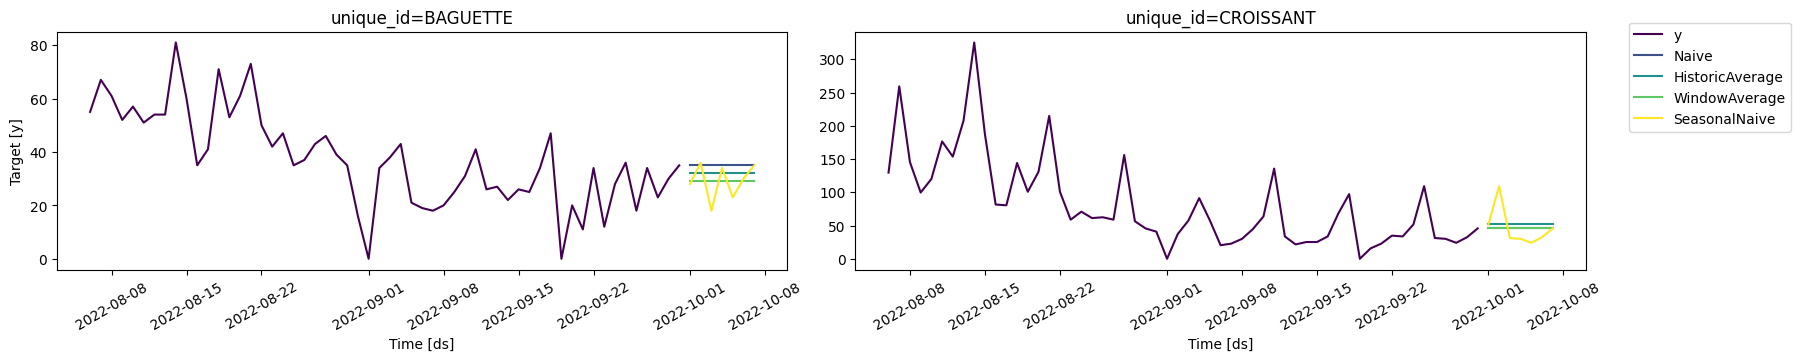

In [8]:
plot_series(df=df, forecasts_df=preds, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

In [9]:
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [10]:
sf.fit(df=train)
preds=sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', on=["ds","unique_id"])
eval_df.head()

,unique_id,ds,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-22,0.0,0.0,9.577465,1.428571,10.0
1,12 MACARON,2022-09-23,0.0,0.0,9.577465,1.428571,0.0
2,12 MACARON,2022-09-24,10.0,0.0,9.577465,1.428571,0.0
3,12 MACARON,2022-09-25,0.0,0.0,9.577465,1.428571,0.0
4,12 MACARON,2022-09-26,0.0,0.0,9.577465,1.428571,0.0


In [11]:
evaluation = evaluate(eval_df, metrics=[mae])
evaluation

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714
...,...,...,...,...,...,...
116,TRIANGLES,mae,0.357143,0.759557,0.357143,0.357143
117,TROPEZIENNE,mae,3.142857,2.335557,3.142857,3.142857
118,TROPEZIENNE FRAMBOISE,mae,0.328571,0.431882,0.328571,0.328571
119,VIENNOISE,mae,4.871429,4.027513,4.085714,3.771429


In [12]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


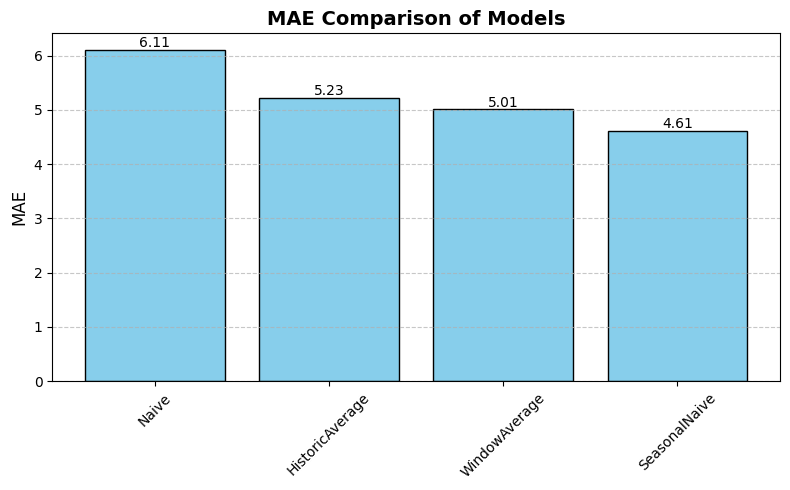

In [13]:
metrics_series = evaluation.drop(columns="metric").iloc[0]


metrics_sorted = metrics_series.sort_values(ascending=False)


plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_sorted.index, metrics_sorted.values, color='skyblue', edgecolor='black')


for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.05,
             f"{bar.get_height():.2f}",
             ha='center', fontsize=10)


plt.title("MAE Comparison of Models", fontsize=14, fontweight='bold')
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

In [15]:
from statsforecast.models import AutoARIMA
models = [AutoARIMA(seasonal=False, alias='ARIMA'), AutoARIMA(season_length=7, alias='SARIMA')]
sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds=sf.predict(h=horizon)
arima_eval_df = pd.merge(arima_preds, eval_df , 'inner', on=["ds","unique_id"])
arima_eval = evaluate(arima_eval_df, metrics=[mae])
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [16]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


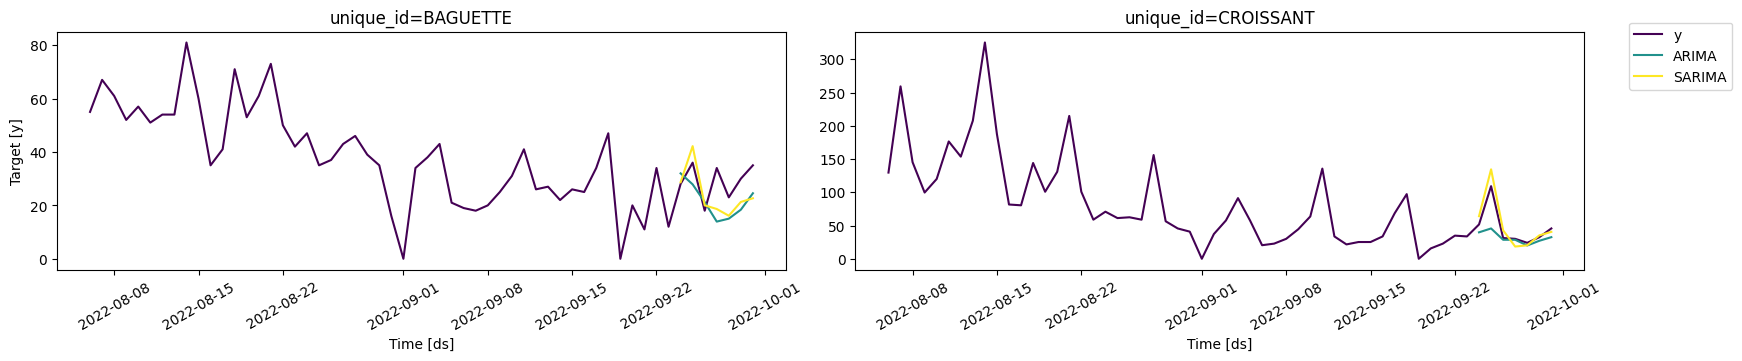

In [17]:
plot_series(df=df, forecasts_df=arima_preds, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

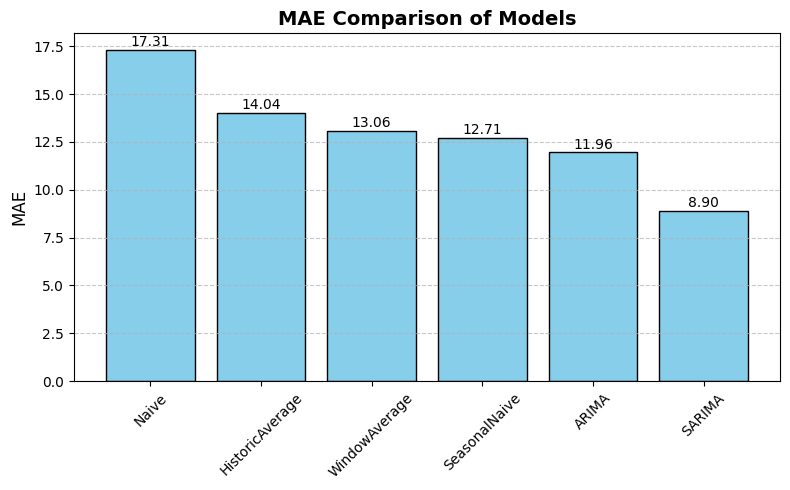

In [18]:
metrics_series = arima_eval.drop(columns="metric").iloc[0]


metrics_sorted = metrics_series.sort_values(ascending=False)


plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_sorted.index, metrics_sorted.values, color='skyblue', edgecolor='black')


for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.2,
             f"{bar.get_height():.2f}",
             ha='center', fontsize=10)


plt.title("MAE Comparison of Models", fontsize=14, fontweight='bold')
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
small_df = df[df["unique_id"].isin(unique_ids)]
models = [SeasonalNaive(season_length=7), AutoARIMA(seasonal=False, alias='ARIMA'), AutoARIMA(season_length=7, alias='SARIMA')]
sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(df=small_df, h=horizon, n_windows=8, step_size=horizon, refit=True)
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


In [20]:
cv_eval_df = evaluate(cv_df.drop(['cutoff'], axis=1), metrics=[mae])
cv_eval_df

,unique_id,metric,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,mae,11.035714,9.028331,8.787206
1,CROISSANT,mae,31.200000,33.313530,29.775386


In [21]:
cv_eval = cv_eval_df.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


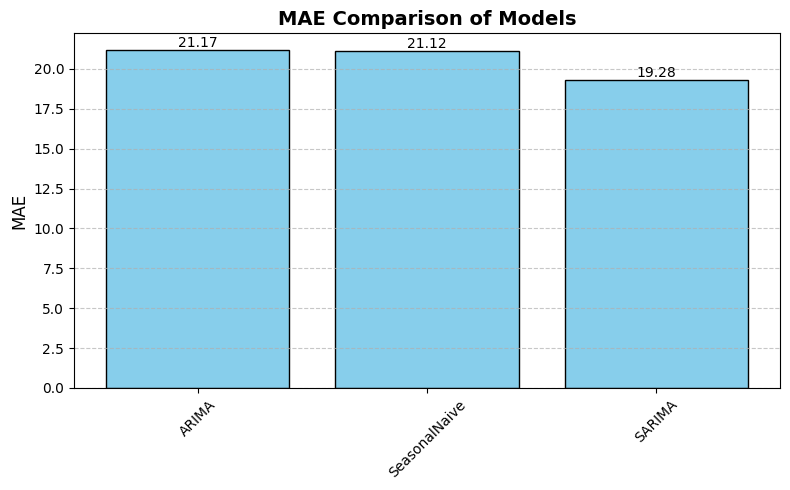

In [22]:
metrics_series = cv_eval.drop(columns="metric").iloc[0]


metrics_sorted = metrics_series.sort_values(ascending=False)


plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_sorted.index, metrics_sorted.values, color='skyblue', edgecolor='black')


for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.2,
             f"{bar.get_height():.2f}",
             ha='center', fontsize=10)


plt.title("MAE Comparison of Models", fontsize=14, fontweight='bold')
plt.ylabel("MAE", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Forecasting with exogenous features

In [23]:
df = pd.read_csv("daily_sales_french_bakery", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


In [24]:
baguette_plot_df = df[df['unique_id'] == 'BAGUETTE']
croissant_plot_df = df[df['unique_id'] == 'CROISSANT']

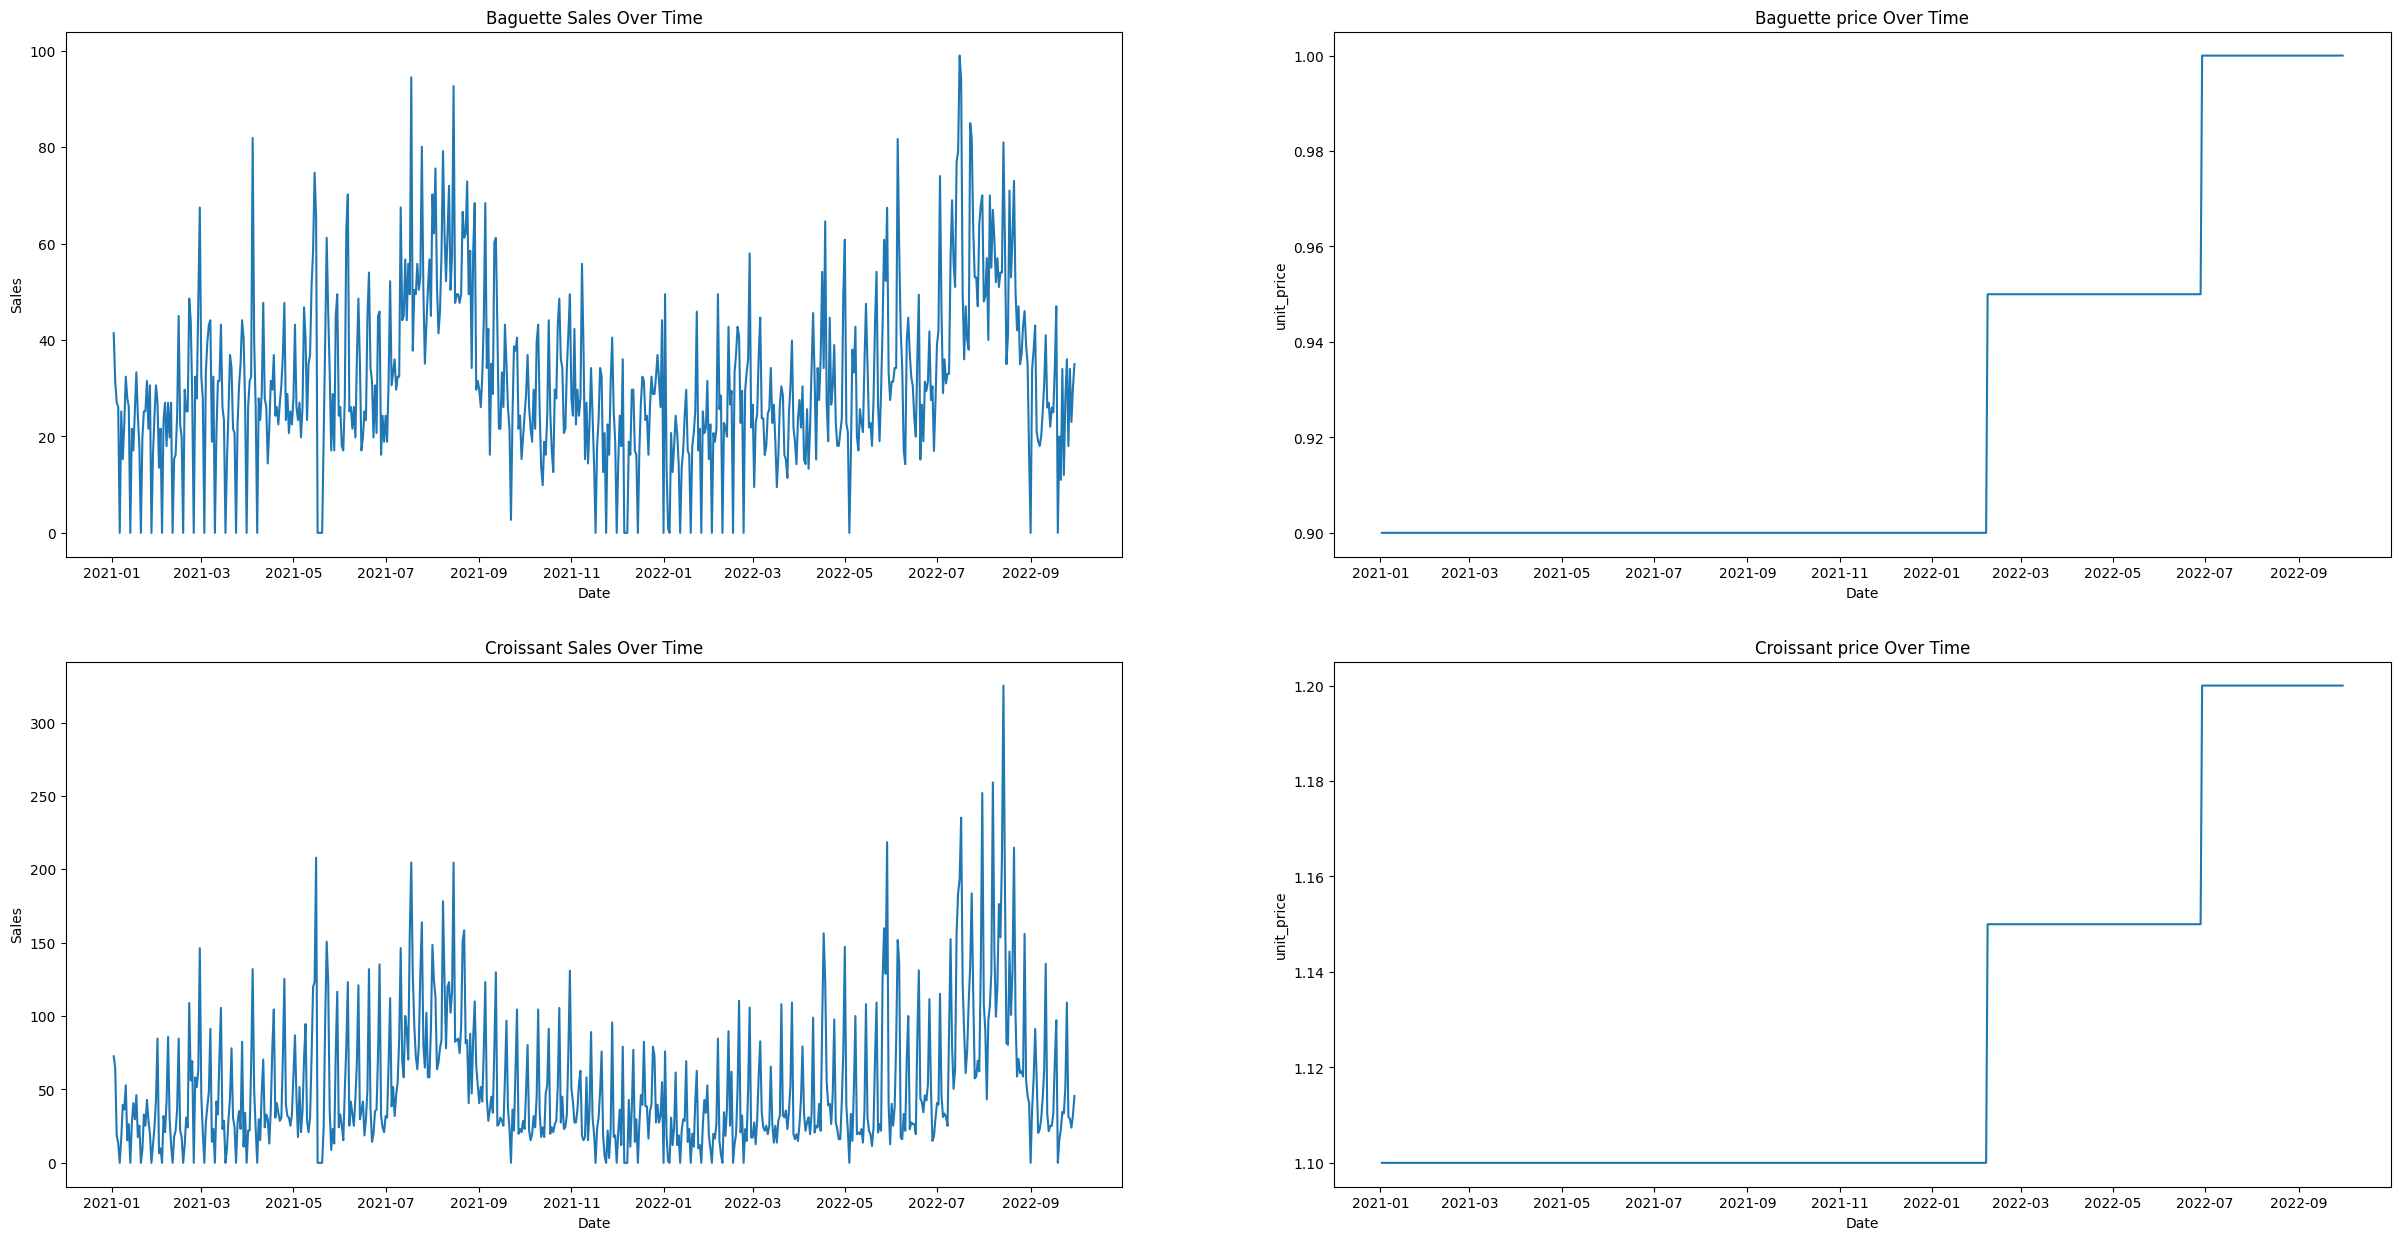

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 15))

ax1.plot(baguette_plot_df['ds'], baguette_plot_df['y'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.set_title('Baguette Sales Over Time')


ax2.plot(baguette_plot_df['ds'], baguette_plot_df['unit_price'])
ax2.set_xlabel('Date')
ax2.set_ylabel('unit_price')
ax2.set_title('Baguette price Over Time')

ax3.plot(croissant_plot_df['ds'], croissant_plot_df['y'])
ax3.set_xlabel('Date')
ax3.set_ylabel('Sales')
ax3.set_title('Croissant Sales Over Time')

ax4.plot(croissant_plot_df['ds'], croissant_plot_df['unit_price'])
ax4.set_xlabel('Date')
ax4.set_ylabel('unit_price')
ax4.set_title('Croissant price Over Time');

In [26]:
unique_ids = ['BAGUETTE', 'CROISSANT']
small_df = df[df['unique_id'].isin(unique_ids)]
test = small_df.groupby('unique_id').tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [27]:
future_exog_df = test.drop(['y'], axis=1)
future_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [28]:
models = [AutoARIMA(season_length=7, alias='SARIMA_exog')]
sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
arima_exog_preds=sf.predict(h=7, X_df=future_exog_df)
arima_exog_preds.head()

,unique_id,ds,SARIMA_exog
0,BAGUETTE,2022-09-24,28.898898
1,BAGUETTE,2022-09-25,42.513264
2,BAGUETTE,2022-09-26,20.423976
3,BAGUETTE,2022-09-27,19.066264
4,BAGUETTE,2022-09-28,16.468885


In [29]:
models = [AutoARIMA(season_length=7, alias='SARIMA')]
sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(['unit_price'], axis=1))
arima_preds=sf.predict(h=7)
arima_preds.head()

,unique_id,ds,SARIMA
0,BAGUETTE,2022-09-24,28.657114
1,BAGUETTE,2022-09-25,42.182373
2,BAGUETTE,2022-09-26,20.013652
3,BAGUETTE,2022-09-27,18.646490
4,BAGUETTE,2022-09-28,16.114925


In [30]:
test_df = pd.merge(test, arima_exog_preds, 'left', on=["ds","unique_id"])\
          .merge(arima_preds, 'left', on=["ds","unique_id"])
test_df.head()

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925


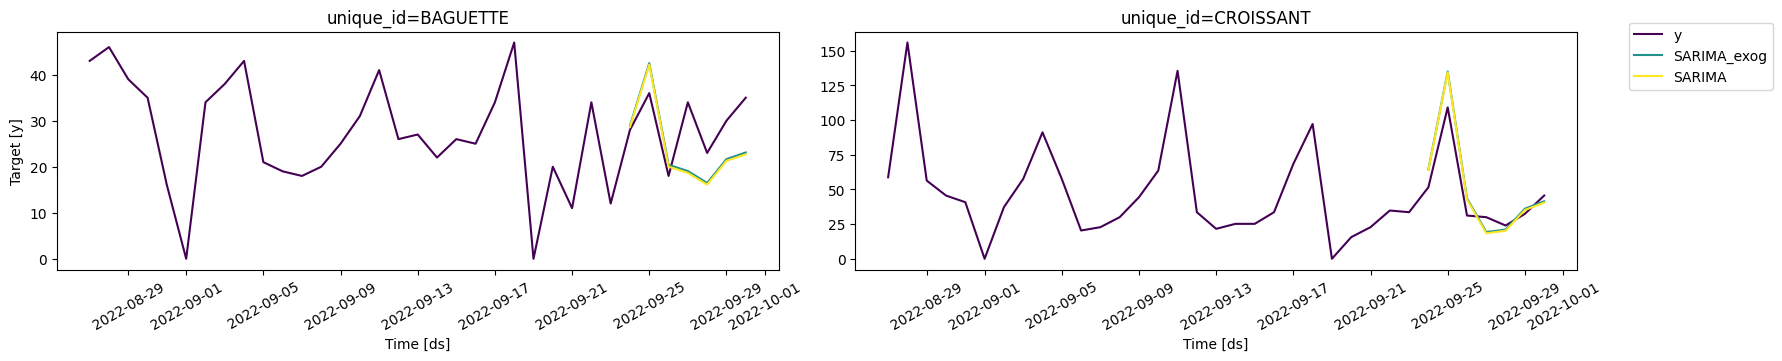

In [31]:
plot_series(df=train, forecasts_df=test_df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=28,models=["SARIMA_exog", "SARIMA"], palette="viridis")

In [32]:
models = [AutoARIMA(season_length=7, alias='SARIMA_exog')]
sf = StatsForecast(models=models, freq="D")
cv_exog_df = sf.cross_validation(df=small_df, h=horizon, n_windows=8, step_size=horizon, refit=True)
cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [33]:
cv_exog_eval_df = evaluate(cv_exog_df.drop(['cutoff'], axis=1), metrics=[mae])
cv_exog_eval_df

,unique_id,metric,SARIMA_exog
0,BAGUETTE,mae,8.934493
1,CROISSANT,mae,29.488880


In [34]:
cv_exog_eval = cv_exog_eval_df.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.211687


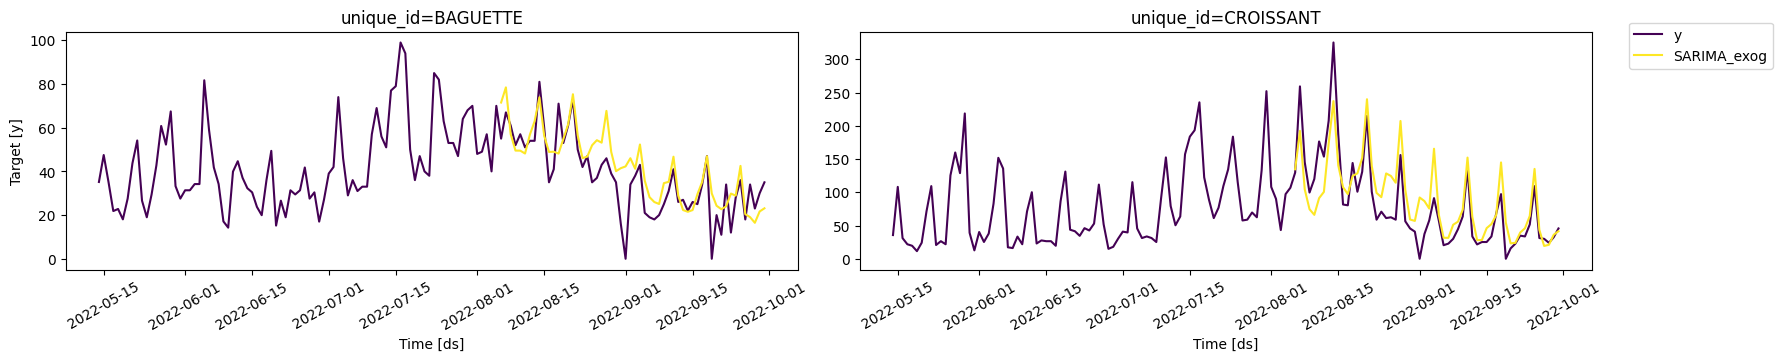

In [35]:
plot_series(
    df=small_df,
    forecasts_df=cv_exog_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=140,
    palette="viridis")

## creating Features from timestamp

In [36]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [37]:
features = [partial(fourier, season_length=7, k=2), partial(time_features, features=['day','week','month'])]
small_exog_df, future_exog_df = pipeline(df=small_df, features=features, freq="D", h=horizon)
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [38]:
future_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [39]:
models = [AutoARIMA(season_length=7, alias='SARIMA_time_exog')]
sf = StatsForecast(models=models, freq="D")
cv_exog_df = sf.cross_validation(df=small_exog_df, h=horizon, n_windows=8, step_size=horizon, refit=True)
cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_time_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,75.374962
1,BAGUETTE,2022-08-07,2022-08-05,67.0,80.970983
2,BAGUETTE,2022-08-08,2022-08-05,61.0,63.397057
3,BAGUETTE,2022-08-09,2022-08-05,52.0,53.371182
4,BAGUETTE,2022-08-10,2022-08-05,57.0,54.755875


In [40]:
cv_exog_eval_df = evaluate(cv_exog_df.drop(['cutoff'], axis=1), metrics=[mae])
cv_exog_eval_df

,unique_id,metric,SARIMA_time_exog
0,BAGUETTE,mae,9.157544
1,CROISSANT,mae,30.285617


In [41]:
cv_exog_eval = cv_exog_eval_df.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_time_exog
0,mae,19.721581


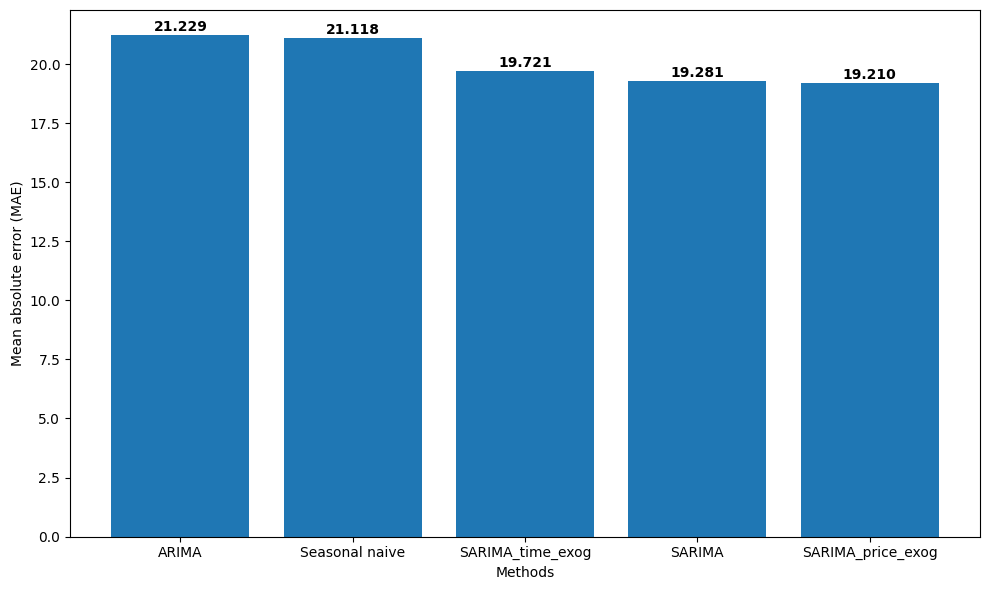

In [44]:
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"]
values = [21.229, 21.118, 19.281, 19.210, 19.721]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

## prediction

In [45]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [46]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [47]:
test.head()

,unique_id,ds,y,unit_price
714,BAGUETTE,2022-09-24,28.0,1.0
715,BAGUETTE,2022-09-25,36.0,1.0
716,BAGUETTE,2022-09-26,18.0,1.0
717,BAGUETTE,2022-09-27,34.0,1.0
718,BAGUETTE,2022-09-28,23.0,1.0


In [48]:
models = [AutoARIMA(season_length=7)]
sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
prob_preds = sf.predict(h=horizon, X_df=test.drop(["y"], axis=1), level=[80])
prob_preds.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,BAGUETTE,2022-09-24,28.898898,15.641064,42.156732
1,BAGUETTE,2022-09-25,42.513264,28.327906,56.698621
2,BAGUETTE,2022-09-26,20.423976,5.891738,34.956214
3,BAGUETTE,2022-09-27,19.066264,4.290843,33.841685
4,BAGUETTE,2022-09-28,16.468885,1.484132,31.453637


In [50]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")
test_df.head()

,unique_id,ds,y,unit_price,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,15.641064,42.156732
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,28.327906,56.698621
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,5.891738,34.956214
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,4.290843,33.841685
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,1.484132,31.453637


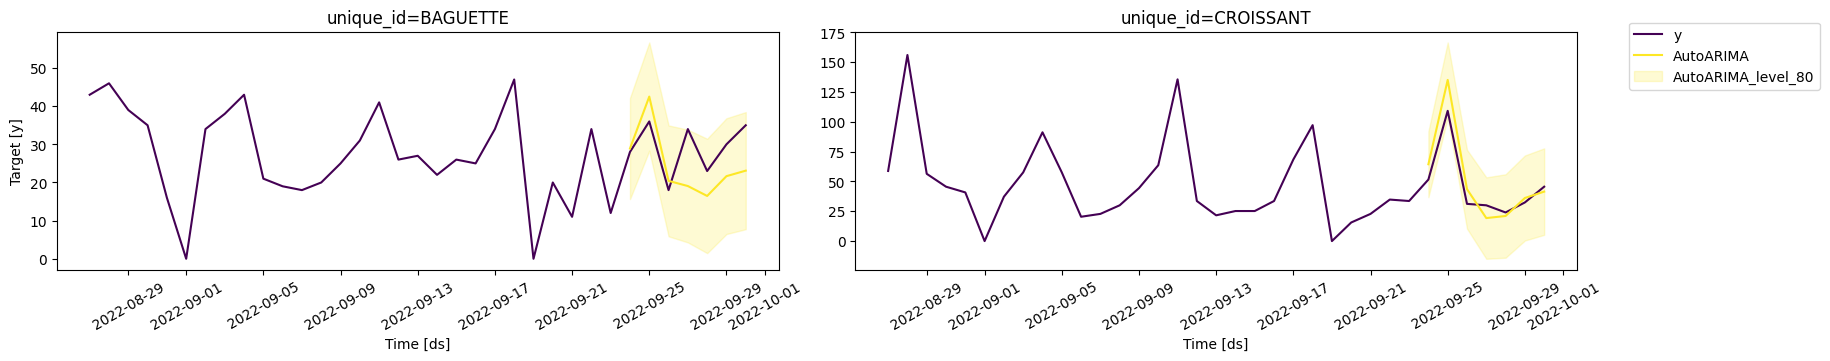

In [52]:
plot_series(df=train, forecasts_df=test_df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=28, models=["AutoARIMA"], level=[80], palette="viridis")

In [53]:
models = [AutoARIMA(season_length=7)]

sf = StatsForecast(
                   models=models,
                   freq="D"
                  )

cv_prob_df = sf.cross_validation(
                                 df=small_df,
                                 h=horizon,
                                 n_windows=8,
                                 step_size=horizon,
                                 refit=True,
                                 level=[80]
                                )

cv_prob_df.head()

,unique_id,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512


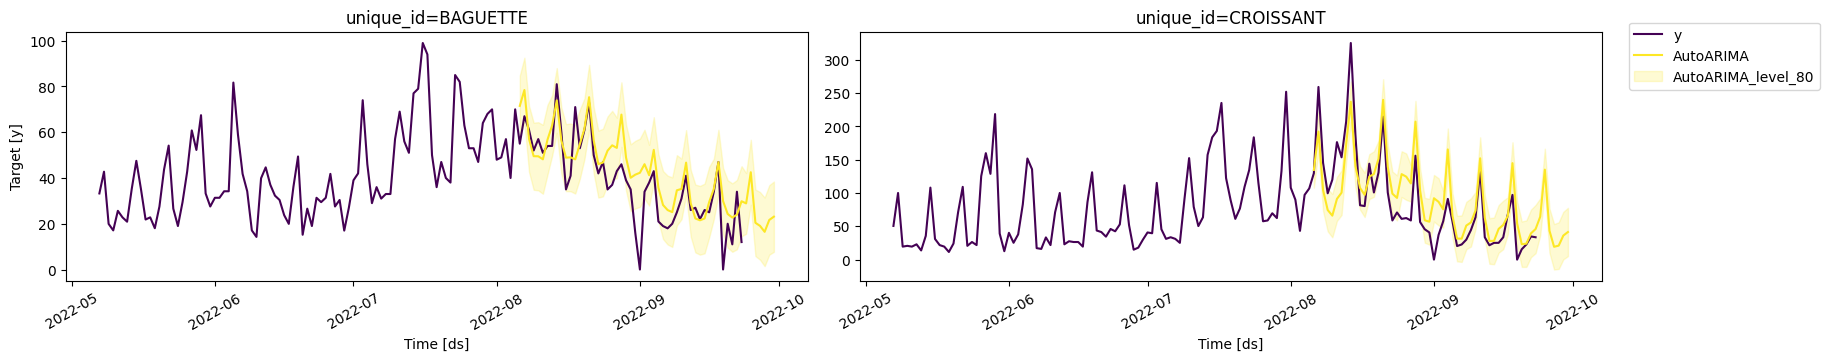

In [55]:
plot_series(
            df=train,
            forecasts_df=cv_prob_df.drop(["y", "cutoff"], axis=1),
            ids=["BAGUETTE", "CROISSANT"],
            max_insample_length=140,
            models=["AutoARIMA"],
            level=[80],
            palette="viridis"
            )

In [56]:
models = [AutoARIMA(season_length=7, alias='SARIMA_exog'), SeasonalNaive(season_length=7)]

sf = StatsForecast(
                   models=models,
                   freq="D"
                  )

final_cv_df = sf.cross_validation(
                                 df=small_df,
                                 h=horizon,
                                 n_windows=8,
                                 step_size=horizon,
                                 refit=True,
                                 level=[80]
                                )

final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [59]:
final_cv_df

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958
...,...,...,...,...,...,...,...,...,...,...
107,CROISSANT,2022-09-26,2022-09-23,31.2,43.526109,10.475177,76.577042,0.0,-40.477848,40.477848
108,CROISSANT,2022-09-27,2022-09-23,30.0,19.290040,-14.837136,53.417215,15.6,-24.877848,56.077848
109,CROISSANT,2022-09-28,2022-09-23,24.0,21.044583,-13.913860,56.003027,22.8,-17.677848,63.277848
110,CROISSANT,2022-09-29,2022-09-23,32.4,36.120334,0.470875,71.769793,34.8,-5.677848,75.277848


In [58]:
temp_test = small_df.groupby('unique_id').tail(7)
temp_train = small_df.drop(temp_test.index).reset_index(drop=True)
temp_train

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9
...,...,...,...,...
1255,CROISSANT,2022-09-19,0.0,1.2
1256,CROISSANT,2022-09-20,15.6,1.2
1257,CROISSANT,2022-09-21,22.8,1.2
1258,CROISSANT,2022-09-22,34.8,1.2


In [60]:
models = ["SARIMA_exog", "SeasonalNaive"]
metrics = [mae,mse, rmse, mape, smape,partial(mase, seasonality=7),scaled_crps]
final_eval = evaluate(final_cv_df.drop(["ds", "cutoff"], axis=1),metrics=metrics,models=models,train_df=temp_train,level=[80])
final_eval = final_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,19.211687,21.117857
1,mape,0.328615,0.376819
2,mase,1.140788,1.285069
3,mse,792.788111,970.417143
4,rmse,24.979598,27.875413
5,scaled_crps,0.153636,0.166451
6,smape,0.168241,0.211317


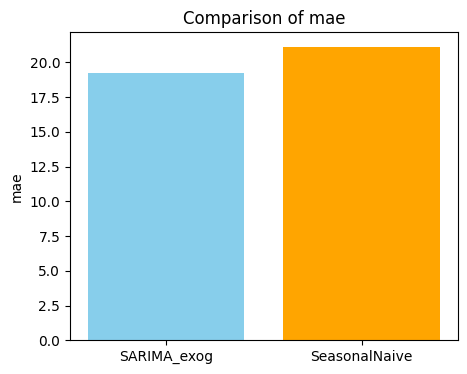

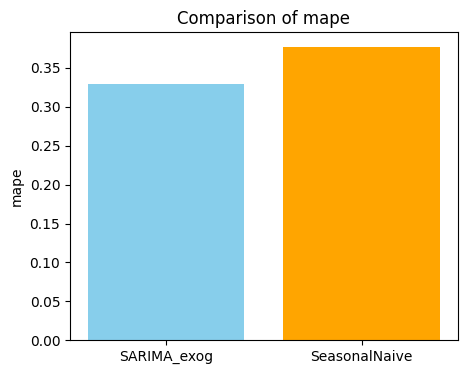

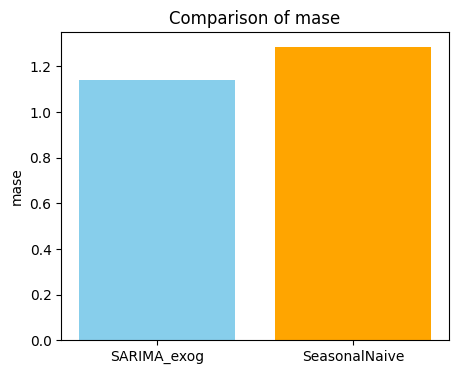

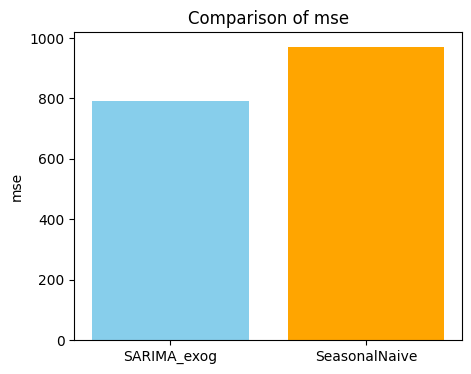

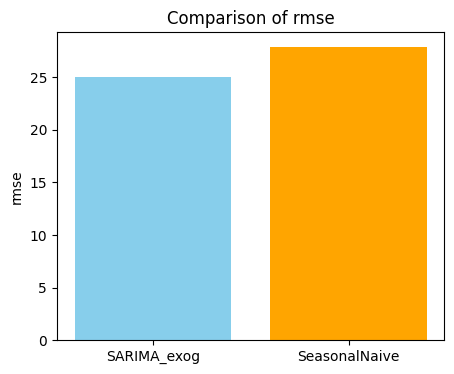

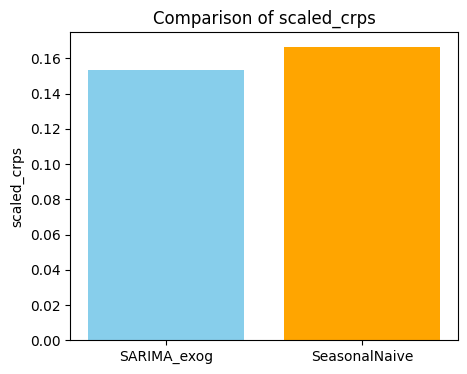

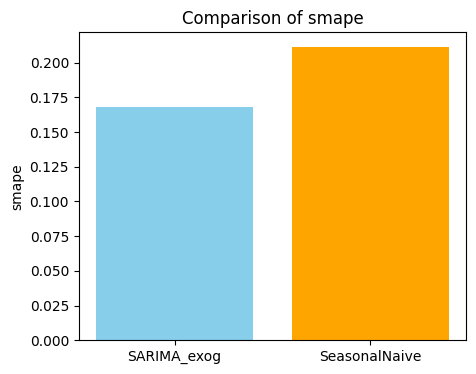

In [62]:
import matplotlib.pyplot as plt

# Loop through each row and plot
for i, row in final_eval.iterrows():
    plt.figure(figsize=(5, 4))
    plt.bar(['SARIMA_exog', 'SeasonalNaive'],
            [row['SARIMA_exog'], row['SeasonalNaive']],
            color=['skyblue', 'orange'])
    plt.title(f"Comparison of {row['metric']}")
    plt.ylabel(row['metric'])
    plt.show()
